In [1]:
%load_ext tensorboard

In [19]:
import os
import json
import numpy as np
import pandas as pd

from alphagen.data.expression import *
from alphagen_generic.features import *
from alphagen_qlib.stock_data import StockData
from alphagen_qlib.calculator import  QLibStockDataCalculator
from utils.tools import parse_formula

# 超参数

In [3]:
trial_name = 'new_csi500_22_0_20240327110009'
data = StockData(instrument="csi500", start_time="2022-01-01", end_time="2024-12-31")

In [4]:
calculator = QLibStockDataCalculator(data, target)

In [5]:
checkpoints_path = os.path.expanduser('~/.project_results/alphagen/checkpoints')
trail_checkpoints_path = os.path.join(checkpoints_path, trial_name)
# os.listdir(trail_checkpoints_path)

In [6]:
def get_raw_pool(file_name='200704_steps_pool.json'):
# 打开 JSON 文件
    with open(os.path.join(trail_checkpoints_path, file_name), 'r', encoding='utf-8') as file:
        # 从文件中加载 JSON 数据并将其转换为字典
        raw = json.load(file)
    return raw
    
    # 现在变量 `data` 将包含文件中的 JSON 数据，以字典的形式存储
def load_alpha_pool(raw):
    exprs_raw = raw['exprs']
    exprs = [eval(expr_raw.replace('$open', 'open_').replace('$', '')) for expr_raw in exprs_raw]
    weights = raw['weights']
    return exprs, weights

def get_pool(file_name='200704_steps_pool.json'):
    raw = get_raw_pool(file_name=file_name)
    return load_alpha_pool(raw)

# 计算因子IC

In [23]:
exprs, weights = get_pool(f'{200704}_steps_pool.json')
exprs[0], exprs[1]

(Mad(Sub(Constant(10.0),Div($high,Div($close,Constant(-5.0)))),40),
 Add(Constant(0.01),Corr(Div(Corr($open,$open,30),Constant(-0.5)),Log(Add($high,Constant(2.0))),20)))

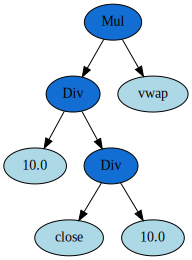

In [27]:
parse_formula(str(exprs[2]))

In [8]:
for expr, weight in zip(exprs, weights):
    ic, rankic = calculator.calc_single_all_ret(expr)
    sign = weight/abs(weight)
    print(ic*sign, rankic*sign, sign)

0.053774625062942505 0.0695439800620079 -1.0
0.0002364662359468639 -0.004390146117657423 -1.0
0.10055819153785706 0.09568143635988235 -1.0
-0.021620173007249832 -0.05434241145849228 -1.0
-0.015248714946210384 -0.027920985594391823 1.0
-0.010454361326992512 0.007562487851828337 1.0
-0.021707573905587196 -0.02960374392569065 1.0
0.021267680451273918 0.02664230205118656 -1.0
0.01119352225214243 0.011984440498054028 -1.0
0.020815495401620865 -0.0008561001741327345 -1.0
0.016346506774425507 0.022320112213492393 -1.0
0.026305725798010826 -5.8268156863050535e-05 -1.0
-0.0045469980686903 0.006127635482698679 -1.0
0.01218471024185419 0.009869174100458622 1.0
-0.02406565472483635 -0.024513108655810356 -1.0
0.023755915462970734 0.05634249374270439 1.0
0.046185385435819626 0.04915844276547432 -1.0
-0.01816524565219879 -0.023482728749513626 1.0
-0.0069715967401862144 -0.009597526863217354 -1.0
-0.02745891362428665 0.0031154847238212824 1.0
-0.02500328980386257 -0.03548483923077583 1.0
0.09119027853

In [9]:
calculator.calc_pool_all_ret(exprs, weights)

(0.09746228903532028, 0.09167450666427612)

# IC曲线，累计收益曲线

In [10]:
# 计算相关系数
def calculate_ic(tensor1, tensor2):
    # 计算每行的相关系数
    row_ic = np.array([np.corrcoef(row1, row2)[0, 1] for row1, row2 in zip(tensor1, tensor2)])
    return row_ic

In [11]:
factor = calculator.make_ensemble_alpha(exprs, weights)

In [12]:
target_value = calculator.target_value

<Axes: >

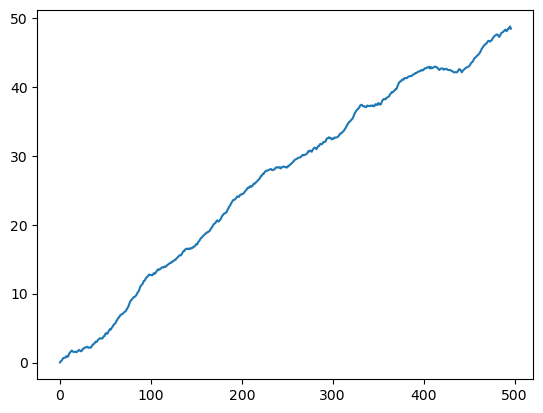

In [13]:
# 计算两个张量的IC
ic_result = calculate_ic(factor.cpu().numpy(), target_value.cpu().numpy())
pd.Series(ic_result).cumsum().plot()

In [14]:
def top_pct_mean(score, pct):
    # 选择打分最高的n个标的计算收益率的均值
    # probs = nn.functional.softmax(score, dim=1)
    # score = probs[:, 1]
    top_num = int(len(score) * 0.2)
    id_col = torch.topk(score, k=top_num, dim=-1)[1]
    id_row = torch.arange(0, score.shape[0]).tile(top_num,1).T
    return pct[id_row, id_col].mean(dim=-1).cpu().numpy()

In [15]:
ret = top_pct_mean(factor, target_value)

<Axes: >

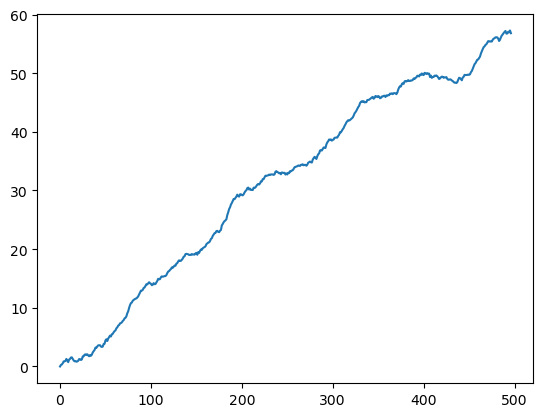

In [16]:
pd.Series(ret).cumsum().plot()

# validation的作用

# tensorboard

In [17]:
log_dir_path = os.path.expanduser('~/.project_results/alphagen/tb_log')
%tensorboard --logdir $log_dir_path

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

<Axes: xlabel='index'>

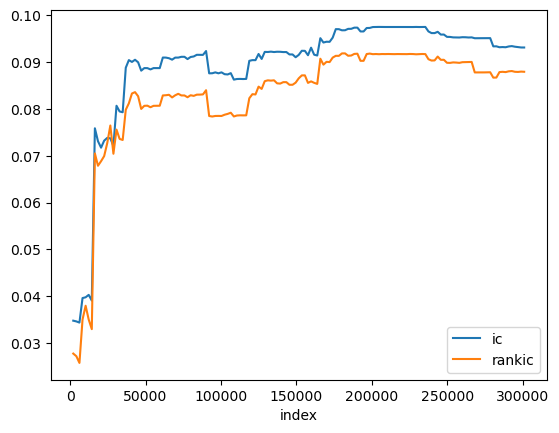

In [18]:
import pandas as pd
res = []
for file_name in os.listdir(trail_checkpoints_path): 
    if file_name.endswith('.json'):
        params= {}
        params['index'] = int(file_name.split('_')[0])
        exprs, weights = get_pool(file_name)
        params['ic'], params['rankic'] = calculator.calc_pool_all_ret(exprs, weights)
        res.append(params)
res = pd.DataFrame(res)
res.set_index('index', inplace=True)
res.sort_index(inplace=True)
res.plot()       